In [24]:
# Import necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import os
import matplotlib.patches as patches

In [52]:
# Load the data
ground_truths_path = 'ground_truths/ground_truths_test.csv'  # Replace with your local path
predicted_times_path = 'results/files/estes.csv'  # Replace with your local path

ground_truths = pd.read_csv(ground_truths_path)
predicted_times = pd.read_csv(predicted_times_path)

# Merge ground truths with predictions based on the image name
comparison = pd.merge(predicted_times, ground_truths, 
                      left_on='Image Name', right_on='Watch', how='inner')


In [53]:
comparison

,Image Name,Predicted Time,Watch,Time
0,watch_test1,10:10:00,watch_test1,10:10:35
1,watch_test2,01:56:00,watch_test2,01:55:44
2,watch_test3,failed,watch_test3,10:54:00
3,watch_test4,05:00:00,watch_test4,02:22:00
4,watch_test5,09:05:00,watch_test5,11:15:00
...,...,...,...,...
113,watch_test114,09:49:00,watch_test114,11:21:36
114,watch_test115,06:09:00,watch_test115,11:36:00
115,watch_test116,12:40:00,watch_test116,12:39:24
116,watch_test117,06:37:00,watch_test117,11:36:00


In [54]:
# Function to convert time string to seconds (without modifying the original dataset)
def time_to_seconds(time_str):
    if time_str == 'failed':
        return None
    time_obj = pd.to_datetime(time_str, format='%H:%M:%S')
    return time_obj.hour * 3600 + time_obj.minute * 60 + time_obj.second

# Creating a copy of the relevant columns for analysis
predicted_times = comparison['Predicted Time'].apply(time_to_seconds)
watch_times = comparison['Time'].apply(time_to_seconds)

# Calculating the absolute error (deviation in seconds)
errors = (predicted_times - watch_times).abs()

# Metric 1: Biggest error and its respective watch
max_error_value = errors.max()
max_error_watch = comparison.loc[errors.idxmax(), 'Image Name']

# Metric 2: Number of watches with 0 deviation (100% correct)
correct_watches_count = (errors == 0).sum()

# Metric 3: Number of watches that are within 5 minutes (300 seconds)
correct_within_5m = (errors <= 300).sum()

# Metric 4: Number of watches that got wrong by at least 1 hour and 30 minutes (5400 seconds)
wrong_by_1hr30m = (errors >= 5400).sum()

# Metric 5: Number of watches that got the time wrong between 5 minutes and 1 hour and 30 minutes (300 to 5400 seconds)
wrong_between_5m_and_1hr30m = ((errors > 300) & (errors < 5400)).sum()

# Print results
print(f"Biggest error: {max_error_value} seconds by {max_error_watch}")
print(f"Number of watches with 0 deviation (100% correct): {correct_watches_count}")
print(f"Number of watches that got the time correct within 5 minutes: {correct_within_5m}")
print(f"Number of watches that got the time wrong by at least 1 hour and 30 minutes: {wrong_by_1hr30m}")
print(f"Number of watches that got the time wrong between 5 minutes and 1 hour and 30 minutes: {wrong_between_5m_and_1hr30m}")



Biggest error: 31440.0 seconds by watch_test56
Number of watches with 0 deviation (100% correct): 6
Number of watches that got the time correct within 5 minutes: 53
Number of watches that got the time wrong by at least 1 hour and 30 minutes: 20
Number of watches that got the time wrong between 5 minutes and 1 hour and 30 minutes: 28


In [55]:
# Define a function to classify as successful or failed based on the "Predicted Time"
def classify_prediction(predicted_time):
    if isinstance(predicted_time, str) and ("failed" in predicted_time.lower() or "detection failed" in predicted_time.lower()):
        return "Failed"
    else:
        return "Successful"

# Apply the classification function to the 'Predicted Time' column
comparison['Prediction Status'] = comparison['Predicted Time'].apply(classify_prediction)

# Calculate the number of successful and failed predictions
successful_predictions = (comparison['Prediction Status'] == "Successful").sum()
failed_predictions = (comparison['Prediction Status'] == "Failed").sum()

# Calculate the ratio of successful to failed detections
total_predictions = len(comparison)
success_ratio = successful_predictions / total_predictions * 100
failure_ratio = failed_predictions / total_predictions * 100

# Output the results
print(f"Total Predictions: {total_predictions}")
print(f"Successful Predictions: {successful_predictions} ({success_ratio:.2f}%)")
print(f"Failed Predictions: {failed_predictions} ({failure_ratio:.2f}%)")


Total Predictions: 118
Successful Predictions: 101 (85.59%)
Failed Predictions: 17 (14.41%)


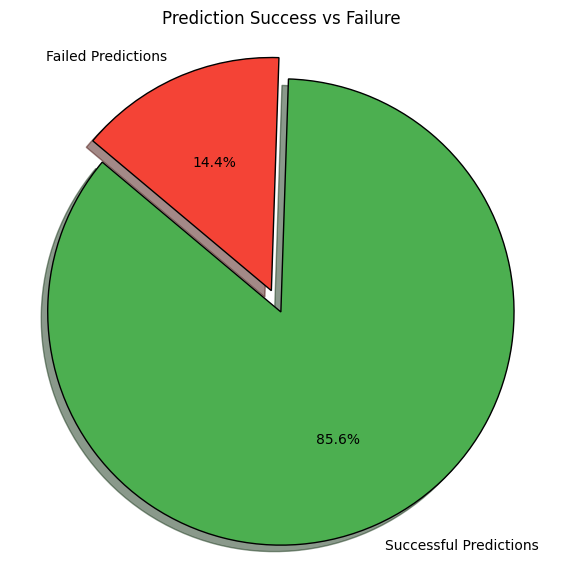

In [56]:
import matplotlib.pyplot as plt

# Data for the pie chart
labels = ['Successful Predictions', 'Failed Predictions']
sizes = [successful_predictions, failed_predictions]
colors = ['#4CAF50', '#F44336']  # Green for successful, red for failed
explode = (0.1, 0)  # Slightly "explode" the successful slice to highlight it

# Plotting the pizza chart
plt.figure(figsize=(7, 7))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, 
        shadow=True, wedgeprops={'edgecolor': 'black'})
plt.title('Prediction Success vs Failure')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.show()


In [57]:
# Convert times to seconds for plotting
def time_to_seconds(time_str):
    """Convert time string (HH:MM:SS) to total seconds."""
    try:
        h, m, s = map(int, time_str.split(':'))
        return h * 3600 + m * 60 + s
    except:
        return None

# Add conversions for seconds, minutes, and hours
comparison['Ground Truth Seconds'] = comparison['Time'].apply(time_to_seconds)
comparison['Predicted Seconds'] = comparison['Predicted Time'].apply(time_to_seconds)

# Convert seconds to minutes and hours
comparison['Ground Truth Minutes'] = comparison['Ground Truth Seconds'] / 60
comparison['Predicted Minutes'] = comparison['Predicted Seconds'] / 60

comparison['Ground Truth Hours'] = comparison['Ground Truth Seconds'] / 3600
comparison['Predicted Hours'] = comparison['Predicted Seconds'] / 3600

# Filter out invalid rows
valid_comparison = comparison.dropna(subset=['Ground Truth Seconds', 'Predicted Seconds'])

# Calculate time differences (absolute value) for seconds, minutes, and hours
valid_comparison['Time Difference (Seconds)'] = (valid_comparison['Predicted Seconds'] - valid_comparison['Ground Truth Seconds']).abs()
valid_comparison['Time Difference (Minutes)'] = (valid_comparison['Predicted Minutes'] - valid_comparison['Ground Truth Minutes']).abs()
valid_comparison['Time Difference (Hours)'] = (valid_comparison['Predicted Hours'] - valid_comparison['Ground Truth Hours']).abs()



c:\Users\pedro\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\Users\pedro\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\Users\pedro\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [58]:
valid_comparison

,Image Name,Predicted Time,Watch,Time,Prediction Status,Ground Truth Seconds,Predicted Seconds,Ground Truth Minutes,Predicted Minutes,Ground Truth Hours,Predicted Hours,Time Difference (Seconds),Time Difference (Minutes),Time Difference (Hours)
0,watch_test1,10:10:00,watch_test1,10:10:35,Successful,36635,36600.0,610.583333,610.0,10.176389,10.166667,35.0,0.583333,0.009722
1,watch_test2,01:56:00,watch_test2,01:55:44,Successful,6944,6960.0,115.733333,116.0,1.928889,1.933333,16.0,0.266667,0.004444
3,watch_test4,05:00:00,watch_test4,02:22:00,Successful,8520,18000.0,142.000000,300.0,2.366667,5.000000,9480.0,158.000000,2.633333
4,watch_test5,09:05:00,watch_test5,11:15:00,Successful,40500,32700.0,675.000000,545.0,11.250000,9.083333,7800.0,130.000000,2.166667
5,watch_test6,08:12:00,watch_test6,03:12:00,Successful,11520,29520.0,192.000000,492.0,3.200000,8.200000,18000.0,300.000000,5.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,watch_test114,09:49:00,watch_test114,11:21:36,Successful,40896,35340.0,681.600000,589.0,11.360000,9.816667,5556.0,92.600000,1.543333
114,watch_test115,06:09:00,watch_test115,11:36:00,Successful,41760,22140.0,696.000000,369.0,11.600000,6.150000,19620.0,327.000000,5.450000
115,watch_test116,12:40:00,watch_test116,12:39:24,Successful,45564,45600.0,759.400000,760.0,12.656667,12.666667,36.0,0.600000,0.010000
116,watch_test117,06:37:00,watch_test117,11:36:00,Successful,41760,23820.0,696.000000,397.0,11.600000,6.616667,17940.0,299.000000,4.983333


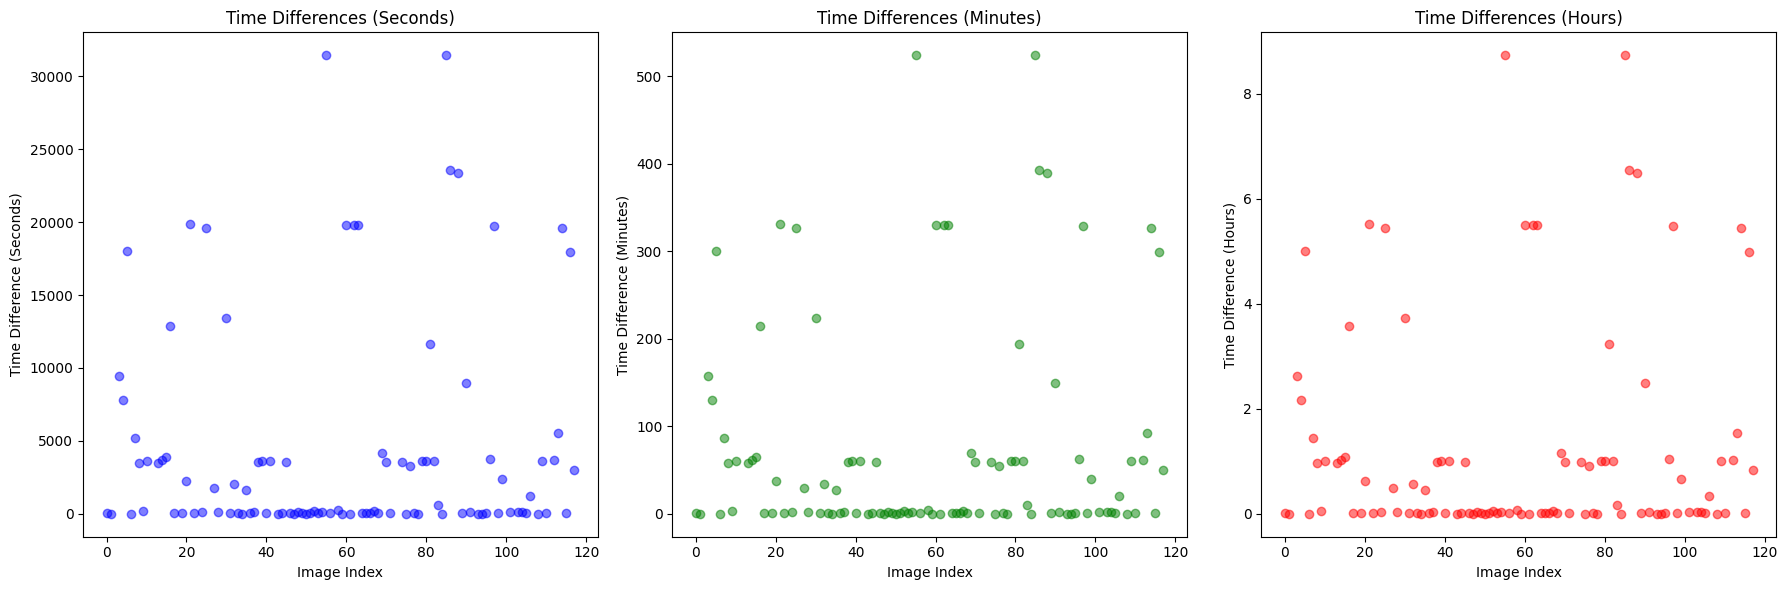

In [59]:
# Plot the time differences for seconds, minutes, and hours
plt.figure(figsize=(18, 6))

# Scatter plot for seconds
plt.subplot(1, 3, 1)
plt.scatter(valid_comparison.index, valid_comparison['Time Difference (Seconds)'], color='blue', alpha=0.5)
plt.xlabel('Image Index')
plt.ylabel('Time Difference (Seconds)')
plt.title('Time Differences (Seconds)')

# Scatter plot for minutes
plt.subplot(1, 3, 2)
plt.scatter(valid_comparison.index, valid_comparison['Time Difference (Minutes)'], color='green', alpha=0.5)
plt.xlabel('Image Index')
plt.ylabel('Time Difference (Minutes)')
plt.title('Time Differences (Minutes)')

# Scatter plot for hours
plt.subplot(1, 3, 3)
plt.scatter(valid_comparison.index, valid_comparison['Time Difference (Hours)'], color='red', alpha=0.5)
plt.xlabel('Image Index')
plt.ylabel('Time Difference (Hours)')
plt.title('Time Differences (Hours)')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [60]:
def calculate_row_std(row):
    # Ensure 'Predicted Time' and 'Time' are in seconds
    predicted_seconds = time_to_seconds(row['Predicted Time'])
    actual_seconds = time_to_seconds(row['Time'])
    
    # Calculate the absolute deviation
    deviation = abs(predicted_seconds - actual_seconds)
    
    # Return the deviation as a standard deviation for this row
    return deviation

# Ensure no duplicate "Deviation" column exists
valid_comparison.drop(columns=['Deviation'], inplace=True, errors='ignore')

# Add new column
valid_comparison['Row Standard Deviation (Seconds)'] = valid_comparison.apply(calculate_row_std, axis=1)

# Rename columns
valid_comparison.rename(columns={
    'Image Name': 'Watches',
    'Row Standard Deviation (Seconds)': 'Deviation'
}, inplace=True)

# Access specific columns
columns_to_save = ['Watches', 'Deviation']

# Ensure the 'Watches' column exists in the subset
data_to_sort = valid_comparison[columns_to_save]

# Extract numeric suffix from 'Watches' and sort by it
data_to_sort['numeric_suffix'] = data_to_sort['Watches'].str.extract(r'(\d+)$').astype(int)
data_to_sort = data_to_sort.sort_values(by='numeric_suffix').drop(columns=['numeric_suffix'])

# Display the sorted DataFrame
data_to_sort.to_csv('Deviation.csv', index=False)

c:\Users\pedro\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
c:\Users\pedro\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\Users\pedro\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

Accuracy (Seconds): 36.63%
Accuracy (Minutes): 36.63%
Accuracy (Hours): 36.63%


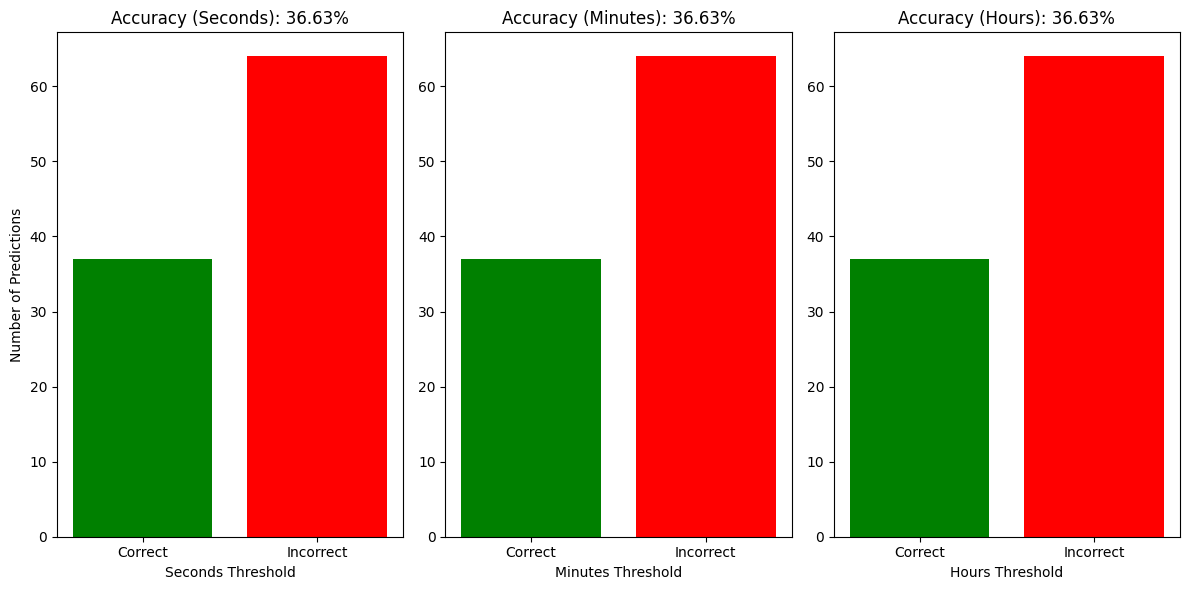

In [61]:
# Define thresholds for each unit
threshold_seconds = 60  
threshold_minutes = 1   
threshold_hours = 0.0167  # approximately 1 minute in hours

# Calculate correct predictions for each unit
correct_seconds = valid_comparison['Time Difference (Seconds)'] <= threshold_seconds
correct_minutes = valid_comparison['Time Difference (Minutes)'] <= threshold_minutes
correct_hours = valid_comparison['Time Difference (Hours)'] <= threshold_hours

# Calculate accuracy percentages
accuracy_seconds = (correct_seconds.sum() / len(valid_comparison)) * 100
accuracy_minutes = (correct_minutes.sum() / len(valid_comparison)) * 100
accuracy_hours = (correct_hours.sum() / len(valid_comparison)) * 100

# Print the accuracy percentages
print(f"Accuracy (Seconds): {accuracy_seconds:.2f}%")
print(f"Accuracy (Minutes): {accuracy_minutes:.2f}%")
print(f"Accuracy (Hours): {accuracy_hours:.2f}%")

# Bar plot for correct vs incorrect predictions for each unit
plt.figure(figsize=(12, 6))

# Seconds
plt.subplot(1, 3, 1)
plt.bar(['Correct', 'Incorrect'], [correct_seconds.sum(), (~correct_seconds).sum()], color=['green', 'red'])
plt.title(f'Accuracy (Seconds): {accuracy_seconds:.2f}%')
plt.ylabel('Number of Predictions')
plt.xlabel('Seconds Threshold')

# Minutes
plt.subplot(1, 3, 2)
plt.bar(['Correct', 'Incorrect'], [correct_minutes.sum(), (~correct_minutes).sum()], color=['green', 'red'])
plt.title(f'Accuracy (Minutes): {accuracy_minutes:.2f}%')
plt.xlabel('Minutes Threshold')

# Hours
plt.subplot(1, 3, 3)
plt.bar(['Correct', 'Incorrect'], [correct_hours.sum(), (~correct_hours).sum()], color=['green', 'red'])
plt.title(f'Accuracy (Hours): {accuracy_hours:.2f}%')
plt.xlabel('Hours Threshold')

plt.tight_layout()
plt.show()


# Standard Deviation 

In [62]:
# Calculate the standard deviation of the time differences
std_dev_seconds = valid_comparison['Time Difference (Seconds)'].std()
std_dev_minutes = valid_comparison['Time Difference (Minutes)'].std()
std_dev_hours = valid_comparison['Time Difference (Hours)'].std()

# Print the standard deviations
print(f"Standard Deviation of Time Differences:")
print(f"  Seconds: {std_dev_seconds:.2f} seconds")
print(f"  Minutes: {std_dev_minutes:.2f} minutes")
print(f"  Hours: {std_dev_hours:.4f} hours")  # Higher precision for small hour values


Standard Deviation of Time Differences:
  Seconds: 7443.04 seconds
  Minutes: 124.05 minutes
  Hours: 2.0675 hours


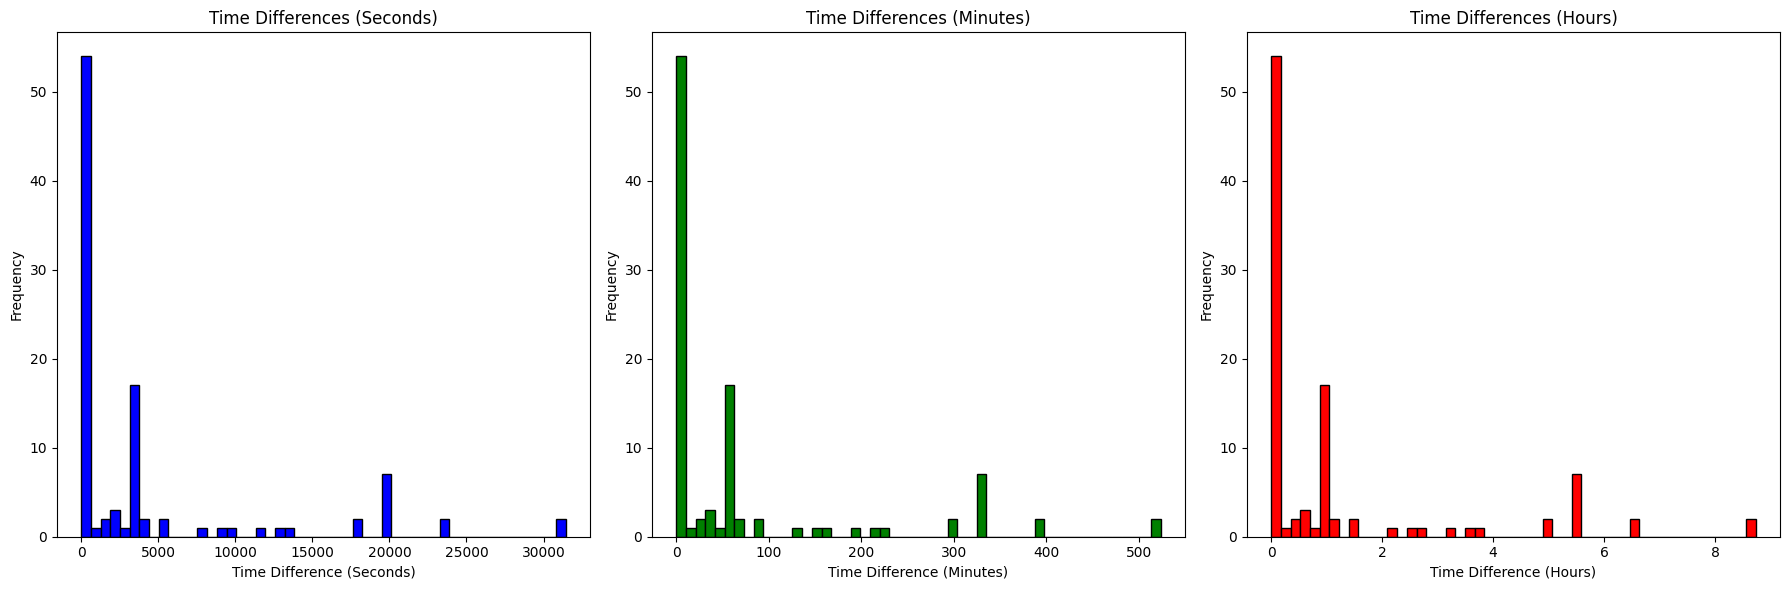

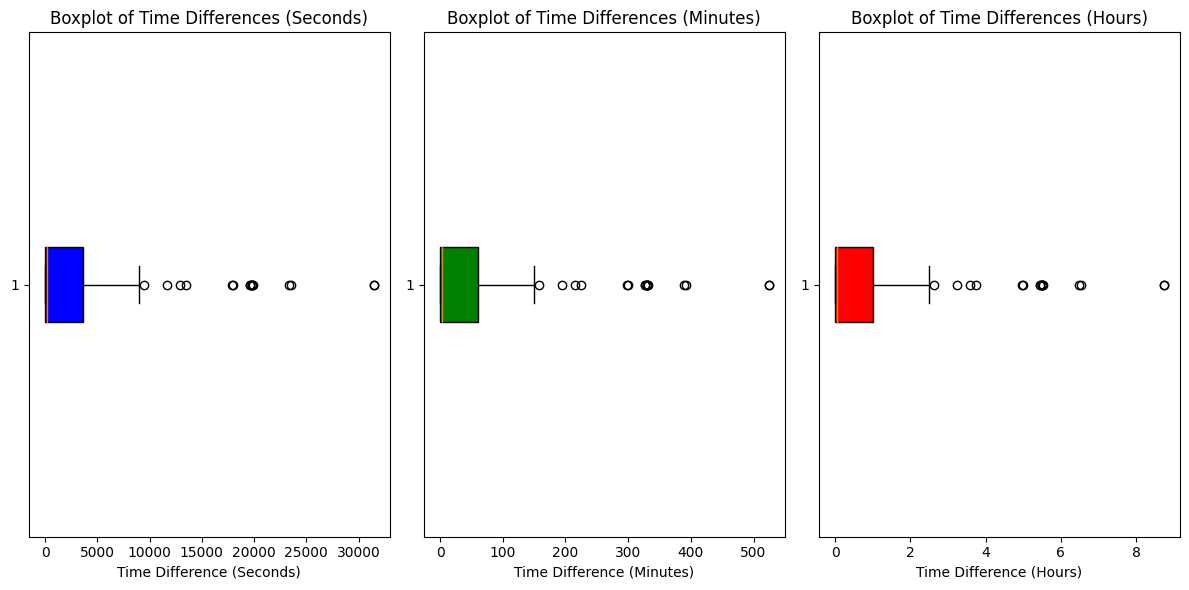

In [63]:
import matplotlib.pyplot as plt

# Plot histograms for seconds, minutes, and hours
plt.figure(figsize=(18, 6))

# Histogram for seconds
plt.subplot(1, 3, 1)
plt.hist(valid_comparison['Time Difference (Seconds)'], bins=50, color='blue', edgecolor='black')
plt.title('Time Differences (Seconds)')
plt.xlabel('Time Difference (Seconds)')
plt.ylabel('Frequency')

# Histogram for minutes
plt.subplot(1, 3, 2)
plt.hist(valid_comparison['Time Difference (Minutes)'], bins=50, color='green', edgecolor='black')
plt.title('Time Differences (Minutes)')
plt.xlabel('Time Difference (Minutes)')
plt.ylabel('Frequency')

# Histogram for hours
plt.subplot(1, 3, 3)
plt.hist(valid_comparison['Time Difference (Hours)'], bins=50, color='red', edgecolor='black')
plt.title('Time Differences (Hours)')
plt.xlabel('Time Difference (Hours)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Plot boxplots for seconds, minutes, and hours
plt.figure(figsize=(12, 6))

# Boxplot for seconds
plt.subplot(1, 3, 1)
plt.boxplot(valid_comparison['Time Difference (Seconds)'], vert=False, patch_artist=True, boxprops=dict(facecolor='blue', color='black'))
plt.title('Boxplot of Time Differences (Seconds)')
plt.xlabel('Time Difference (Seconds)')

# Boxplot for minutes
plt.subplot(1, 3, 2)
plt.boxplot(valid_comparison['Time Difference (Minutes)'], vert=False, patch_artist=True, boxprops=dict(facecolor='green', color='black'))
plt.title('Boxplot of Time Differences (Minutes)')
plt.xlabel('Time Difference (Minutes)')

# Boxplot for hours
plt.subplot(1, 3, 3)
plt.boxplot(valid_comparison['Time Difference (Hours)'], vert=False, patch_artist=True, boxprops=dict(facecolor='red', color='black'))
plt.title('Boxplot of Time Differences (Hours)')
plt.xlabel('Time Difference (Hours)')

plt.tight_layout()
plt.show()


In [64]:
# Define outlier thresholds
outlier_threshold_seconds = 3600  # in seconds
outlier_threshold_minutes = outlier_threshold_seconds / 60  # in minutes
outlier_threshold_hours = outlier_threshold_seconds / 3600  # in hours

# Filter out time differences above the threshold for each unit
filtered_comparison_seconds = valid_comparison[valid_comparison['Time Difference (Seconds)'].abs() <= outlier_threshold_seconds]
filtered_comparison_minutes = valid_comparison[valid_comparison['Time Difference (Minutes)'].abs() <= outlier_threshold_minutes]
filtered_comparison_hours = valid_comparison[valid_comparison['Time Difference (Hours)'].abs() <= outlier_threshold_hours]

# Recalculate the standard deviation without outliers
filtered_std_dev_seconds = filtered_comparison_seconds['Time Difference (Seconds)'].std()
filtered_std_dev_minutes = filtered_comparison_minutes['Time Difference (Minutes)'].std()
filtered_std_dev_hours = filtered_comparison_hours['Time Difference (Hours)'].std()

# Print the recalculated standard deviations
print("Standard Deviation without Outliers:")
print(f"  Seconds: {filtered_std_dev_seconds:.2f} seconds")
print(f"  Minutes: {filtered_std_dev_minutes:.2f} minutes")
print(f"  Hours: {filtered_std_dev_hours:.4f} hours")



Standard Deviation without Outliers:
  Seconds: 1293.81 seconds
  Minutes: 21.56 minutes
  Hours: 0.3594 hours


# Mean Absolute Error

In [65]:
import numpy as np

def mean_absolute_error_with_threshold(y_true, y_pred, threshold=None):
    """
    Calculate the Mean Absolute Error (MAE) with an optional threshold for outliers.
    
    Args:
    - y_true: Array-like of ground truth values.
    - y_pred: Array-like of predicted values.
    - threshold: Optional; exclude errors above this threshold.
    
    Returns:
    - Mean absolute error, or None if no data remains after thresholding.
    """
    # Calculate the absolute errors
    errors = np.abs(y_true - y_pred)
    
    # Apply threshold to filter out outliers if provided
    if threshold is not None:
        errors = errors[errors <= threshold]
    
    # Return the mean of the errors, or None if no valid errors remain
    return np.mean(errors) if len(errors) > 0 else None

# Threshold values for each unit
threshold_seconds = 3600  # in seconds
threshold_minutes = threshold_seconds / 60  # in minutes
threshold_hours = threshold_seconds / 3600  # in hours

# Calculate MAE for each unit
mae_seconds = mean_absolute_error_with_threshold(
    valid_comparison['Ground Truth Seconds'], 
    valid_comparison['Predicted Seconds'], 
    threshold=threshold_seconds
)

mae_minutes = mean_absolute_error_with_threshold(
    valid_comparison['Ground Truth Minutes'], 
    valid_comparison['Predicted Minutes'], 
    threshold=threshold_minutes
)

mae_hours = mean_absolute_error_with_threshold(
    valid_comparison['Ground Truth Hours'], 
    valid_comparison['Predicted Hours'], 
    threshold=threshold_hours
)

# Print results
print(f"Mean Absolute Error (MAE) with threshold:")
print(f"  Seconds: {mae_seconds:.2f} seconds")
print(f"  Minutes: {mae_minutes:.2f} minutes")
print(f"  Hours: {mae_hours:.4f} hours")



Mean Absolute Error (MAE) with threshold:
  Seconds: 750.11 seconds
  Minutes: 12.50 minutes
  Hours: 0.2084 hours


# Bias

In [66]:
# Calculate the bias (mean error) for each unit
bias_seconds = (valid_comparison['Predicted Seconds'] - valid_comparison['Ground Truth Seconds']).mean()
bias_minutes = (valid_comparison['Predicted Minutes'] - valid_comparison['Ground Truth Minutes']).mean()
bias_hours = (valid_comparison['Predicted Hours'] - valid_comparison['Ground Truth Hours']).mean()

# Print the biases
print("Bias (Mean Error):")
print(f"  Seconds: {bias_seconds:.2f} seconds")
print(f"  Minutes: {bias_minutes:.2f} minutes")
print(f"  Hours: {bias_hours:.4f} hours")


Bias (Mean Error):
  Seconds: -163.04 seconds
  Minutes: -2.72 minutes
  Hours: -0.0453 hours


# Error Distribution

c:\Users\pedro\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\Users\pedro\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\Users\pedro\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be

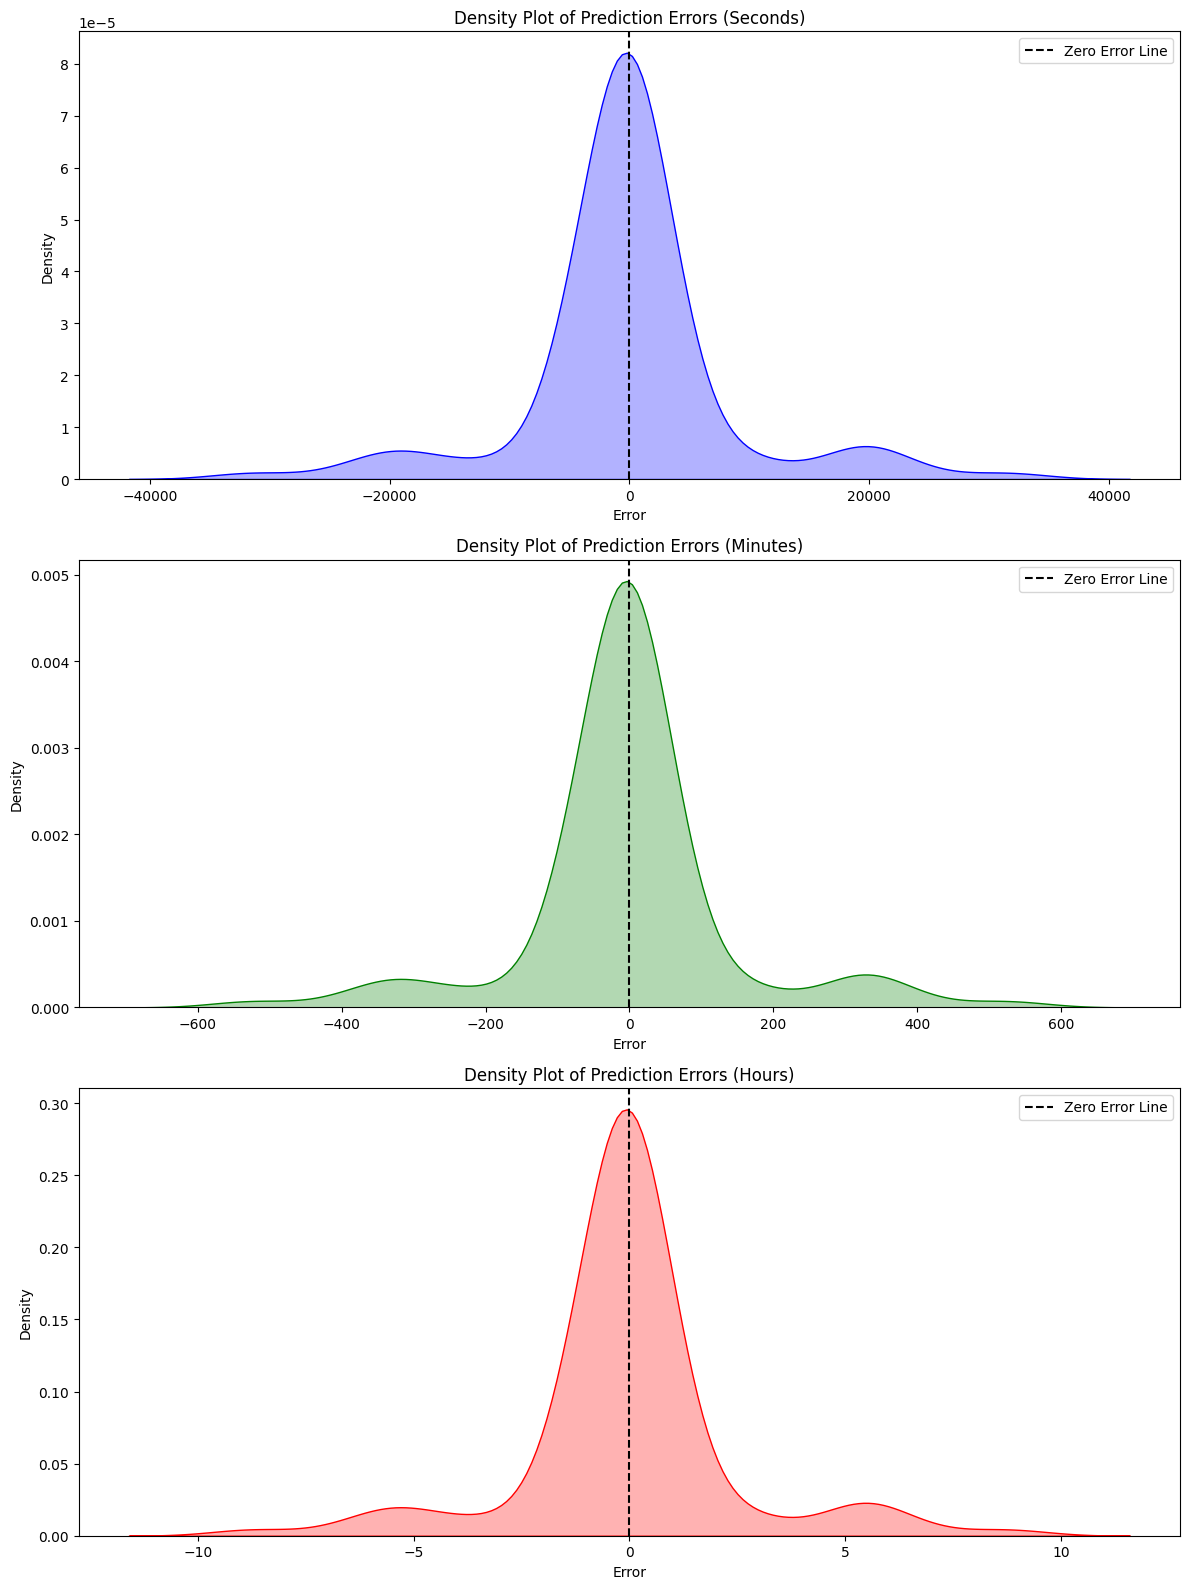

In [67]:
# Calculate prediction errors for each time unit
valid_comparison['Error (Seconds)'] = valid_comparison['Predicted Seconds'] - valid_comparison['Ground Truth Seconds']
valid_comparison['Error (Minutes)'] = valid_comparison['Predicted Minutes'] - valid_comparison['Ground Truth Minutes']
valid_comparison['Error (Hours)'] = valid_comparison['Predicted Hours'] - valid_comparison['Ground Truth Hours']

# Individual density plots for better visualization
fig, axes = plt.subplots(3, 1, figsize=(12, 16), sharex=False)

# Seconds
sns.kdeplot(valid_comparison['Error (Seconds)'], color='blue', fill=True, alpha=0.3, ax=axes[0])
axes[0].set_title('Density Plot of Prediction Errors (Seconds)')
axes[0].axvline(0, color='black', linestyle='--', label='Zero Error Line')
axes[0].legend()

# Minutes
sns.kdeplot(valid_comparison['Error (Minutes)'], color='green', fill=True, alpha=0.3, ax=axes[1])
axes[1].set_title('Density Plot of Prediction Errors (Minutes)')
axes[1].axvline(0, color='black', linestyle='--', label='Zero Error Line')
axes[1].legend()

# Hours
sns.kdeplot(valid_comparison['Error (Hours)'], color='red', fill=True, alpha=0.3, ax=axes[2])
axes[2].set_title('Density Plot of Prediction Errors (Hours)')
axes[2].axvline(0, color='black', linestyle='--', label='Zero Error Line')
axes[2].legend()

# Add labels
for ax in axes:
    ax.set_xlabel('Error')
    ax.set_ylabel('Density')

plt.tight_layout()
plt.show()




# Correlation Coefficient

In [68]:
# Calculate Pearson correlation coefficients for each unit
correlation_seconds = valid_comparison['Ground Truth Seconds'].corr(valid_comparison['Predicted Seconds'])
correlation_minutes = valid_comparison['Ground Truth Minutes'].corr(valid_comparison['Predicted Minutes'])
correlation_hours = valid_comparison['Ground Truth Hours'].corr(valid_comparison['Predicted Hours'])

# Print the correlation coefficients
print(f"Correlation Coefficient:")
print(f"  Seconds: {correlation_seconds:.4f}")
print(f"  Minutes: {correlation_minutes:.4f}")
print(f"  Hours: {correlation_hours:.4f}")


Correlation Coefficient:
  Seconds: 0.7596
  Minutes: 0.7596
  Hours: 0.7596


# Bounding Boxes

In [69]:
import os
import csv

# Define the folder path (replace this with the actual path to your folder containing the txt files)
folder_path = 'dataset/labels/val'
output_csv = 'truth.csv'

# Open the CSV file in write mode
with open(output_csv, mode='w', newline='') as csvfile:
    fieldnames = ['watch', '0_xmin', '0_ymin', '0_xmax', '0_ymax', 
                  '1_xmin', '1_ymin', '1_xmax', '1_ymax', 
                  '2_xmin', '2_ymin', '2_xmax', '2_ymax', 
                  '3_xmin', '3_ymin', '3_xmax', '3_ymax', 
                  '4_xmin', '4_ymin', '4_xmax', '4_ymax']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

    # Process each .txt file in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith('.txt'):
            filepath = os.path.join(folder_path, filename)
            
            # Read the contents of the txt file
            with open(filepath, 'r') as file:
                lines = file.readlines()

            # Create an empty row to hold the bounding box values
            row = {'watch': filename}

            # Initialize a dictionary to store the values for all classes (0-4)
            boxes = {f'{i}_xmin': '0' for i in range(5)}
            boxes.update({f'{i}_ymin': '0' for i in range(5)})
            boxes.update({f'{i}_xmax': '0' for i in range(5)})
            boxes.update({f'{i}_ymax': '0' for i in range(5)})

            # Loop through each line in the txt file and extract values
            for line in lines:
                parts = line.split()
                if len(parts) == 5:  # Make sure the line has 5 parts: class, xmin, ymin, xmax, ymax
                    cls, xmin, ymin, xmax, ymax = parts
                    # Assign the extracted values to the correct class in the boxes dictionary
                    boxes[f'{cls}_xmin'] = xmin
                    boxes[f'{cls}_ymin'] = ymin
                    boxes[f'{cls}_xmax'] = xmax
                    boxes[f'{cls}_ymax'] = ymax

            # Add the bounding box values to the row dictionary
            row.update(boxes)

            # Write the row to the CSV
            writer.writerow(row)


In [115]:
import pandas as pd
import numpy as np

# Load the data
truth_path = 'bb_csvs/truth.csv'
pred_path = 'bb_csvs/pred.csv'

ground_truth = pd.read_csv(truth_path)
predictions = pd.read_csv(pred_path)

# Ensure the files have the same structure
if not (ground_truth.columns == predictions.columns).all():
    raise ValueError("The structure of ground truth and prediction files must match.")

# Convert bounding box columns to numeric, coerce errors to NaN
bbox_columns = [col for col in ground_truth.columns if any(sub in col for sub in ['xmin', 'ymin', 'xmax', 'ymax'])]

ground_truth[bbox_columns] = ground_truth[bbox_columns].apply(pd.to_numeric, errors='coerce')
predictions[bbox_columns] = predictions[bbox_columns].apply(pd.to_numeric, errors='coerce')

# Calculate deviations for each bounding box coordinate for each class (0, 1, 2, 3, 4)
classes = [0, 1, 2, 3, 4]
deviation_data = []

for idx, row in ground_truth.iterrows():
    pred_row = predictions.iloc[idx]
    file_name = row['watch']
    for cls in classes:
        x_min_truth, y_min_truth, x_max_truth, y_max_truth = row[f'{cls}_xmin'], row[f'{cls}_ymin'], row[f'{cls}_xmax'], row[f'{cls}_ymax']
        x_min_pred, y_min_pred, x_max_pred, y_max_pred = pred_row[f'{cls}_xmin'], pred_row[f'{cls}_ymin'], pred_row[f'{cls}_xmax'], pred_row[f'{cls}_ymax']

        deviation_data.append({
            'file': file_name,
            'class': cls,
            'x_min_dev': abs(x_min_truth - x_min_pred),
            'y_min_dev': abs(y_min_truth - y_min_pred),
            'x_max_dev': abs(x_max_truth - x_max_pred),
            'y_max_dev': abs(y_max_truth - y_max_pred)
        })

# Convert to DataFrame
deviation_df = pd.DataFrame(deviation_data)

# Aggregate deviations by class
deviation_summary = deviation_df.groupby('class')[['x_min_dev', 'y_min_dev', 'x_max_dev', 'y_max_dev']].mean()

# Save the deviation summary to a CSV file
output_path = 'deviation_summary.csv'
deviation_summary.to_csv(output_path)

print(f"Deviation summary calculated and saved to {output_path}")

Deviation summary calculated and saved to deviation_summary.csv


In [117]:
import pandas as pd
import numpy as np

truth_path = 'bb_csvs/truth.csv'
pred_path = 'bb_csvs/pred.csv'

ground_truth = pd.read_csv(truth_path)
predictions = pd.read_csv(pred_path)

# Ensure the files have the same structure
if not (ground_truth.columns == predictions.columns).all():
    raise ValueError("The structure of ground truth and prediction files must match.")

# Convert bounding box columns to numeric, coerce errors to NaN
bbox_columns = [col for col in ground_truth.columns if any(sub in col for sub in ['xmin', 'ymin', 'xmax', 'ymax'])]

ground_truth[bbox_columns] = ground_truth[bbox_columns].apply(pd.to_numeric, errors='coerce')
predictions[bbox_columns] = predictions[bbox_columns].apply(pd.to_numeric, errors='coerce')

# Calculate deviations for each bounding box coordinate for each class (0, 1, 2, 3, 4)
classes = [0, 1, 2, 3, 4]
deviation_data = []

for idx, row in ground_truth.iterrows():
    pred_row = predictions.iloc[idx]
    file_name = row['watch']
    for cls in classes:
        x_min_truth, y_min_truth, x_max_truth, y_max_truth = row[f'{cls}_xmin'], row[f'{cls}_ymin'], row[f'{cls}_xmax'], row[f'{cls}_ymax']
        x_min_pred, y_min_pred, x_max_pred, y_max_pred = pred_row[f'{cls}_xmin'], pred_row[f'{cls}_ymin'], pred_row[f'{cls}_xmax'], pred_row[f'{cls}_ymax']

        deviation_data.append({
            'file': file_name,
            'class': cls,
            'x_min_dev': abs(x_min_truth - x_min_pred),
            'y_min_dev': abs(y_min_truth - y_min_pred),
            'x_max_dev': abs(x_max_truth - x_max_pred),
            'y_max_dev': abs(y_max_truth - y_max_pred)
        })

# Convert to DataFrame
deviation_df = pd.DataFrame(deviation_data)

# Aggregate deviations by class
deviation_summary = deviation_df.groupby('class')[['x_min_dev', 'y_min_dev', 'x_max_dev', 'y_max_dev']].mean()

# Print the deviation summary as a table
print("Deviation Summary:")
deviation_summary


Deviation Summary:


,x_min_dev,y_min_dev,x_max_dev,y_max_dev
class,,,,
0,0.001641,0.001826,0.005628,0.005110
1,0.002760,0.001457,0.004293,0.003280
2,0.009115,0.008465,0.007456,0.004736
3,0.023400,0.022753,0.010384,0.010973
4,0.011662,0.008680,0.004391,0.005242


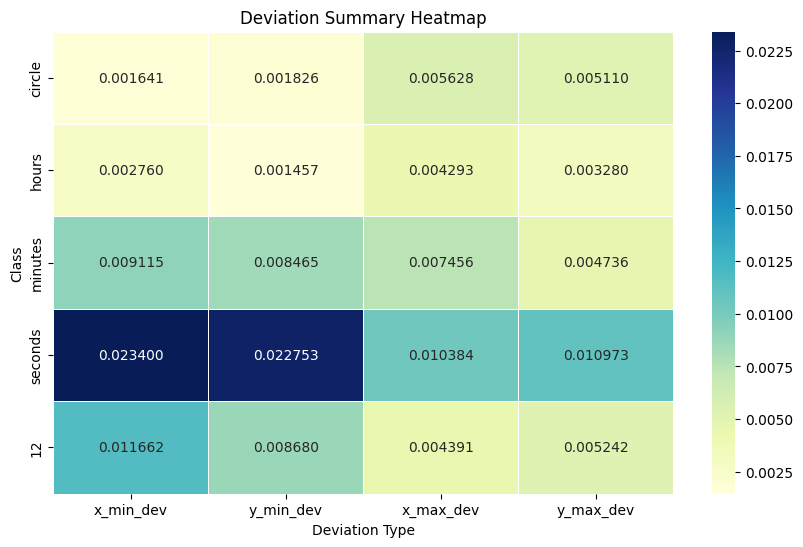

In [123]:
deviation_summary.index = ['circle', 'hours', 'minutes', 'seconds', '12']

# Set up the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(deviation_summary, annot=True, cmap="YlGnBu", fmt='.6f', linewidths=0.5)

# Customize plot labels and title
plt.title('Deviation Summary Heatmap')
plt.xlabel('Deviation Type')
plt.ylabel('Class')

# Show the heatmap
plt.show()

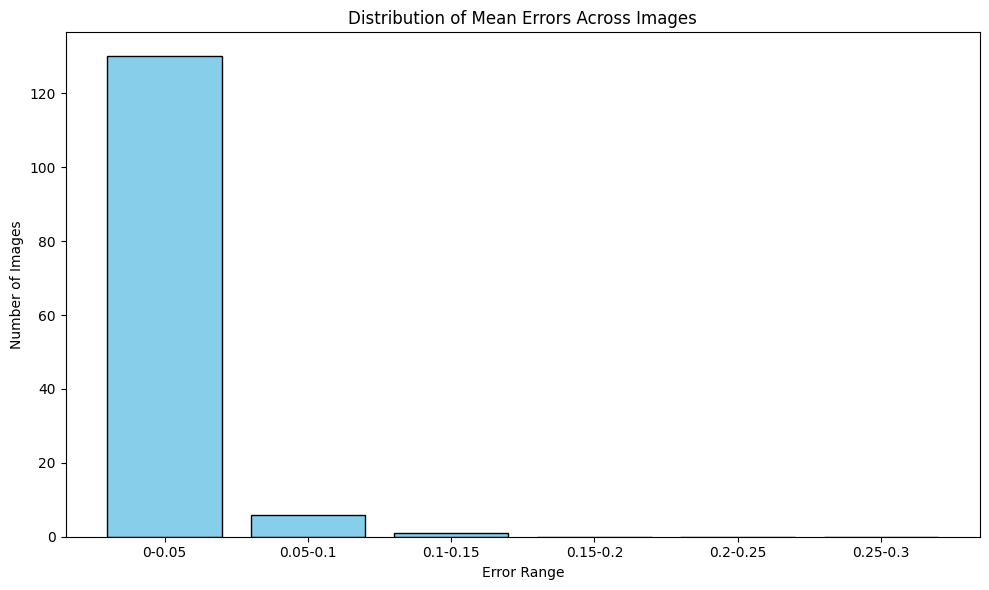

In [121]:

# Read CSV files
ground_truth = pd.read_csv(truth_path)
predictions = pd.read_csv(pred_path)

# Ensure the files have the same structure
if not (ground_truth.columns == predictions.columns).all():
    raise ValueError("The structure of ground truth and prediction files must match.")

# Convert bounding box columns to numeric, coerce errors to NaN
bbox_columns = [col for col in ground_truth.columns if any(sub in col for sub in ['xmin', 'ymin', 'xmax', 'ymax'])]

ground_truth[bbox_columns] = ground_truth[bbox_columns].apply(pd.to_numeric, errors='coerce')
predictions[bbox_columns] = predictions[bbox_columns].apply(pd.to_numeric, errors='coerce')

# Calculate mean error for each image
classes = [0, 1, 2, 3, 4]
errors = []

for idx, row in ground_truth.iterrows():
    pred_row = predictions.iloc[idx]
    file_name = row['watch']
    total_error = 0
    count = 0

    for cls in classes:
        x_min_truth, y_min_truth, x_max_truth, y_max_truth = row[f'{cls}_xmin'], row[f'{cls}_ymin'], row[f'{cls}_xmax'], row[f'{cls}_ymax']
        x_min_pred, y_min_pred, x_max_pred, y_max_pred = pred_row[f'{cls}_xmin'], pred_row[f'{cls}_ymin'], pred_row[f'{cls}_xmax'], pred_row[f'{cls}_ymax']

        if not pd.isna(x_min_truth) and not pd.isna(x_min_pred):
            total_error += abs(x_min_truth - x_min_pred)
            total_error += abs(y_min_truth - y_min_pred)
            total_error += abs(x_max_truth - x_max_pred)
            total_error += abs(y_max_truth - y_max_pred)
            count += 4

    mean_error = total_error / count if count > 0 else 0
    errors.append({'file': file_name, 'mean_error': mean_error})

# Create a DataFrame for errors
errors_df = pd.DataFrame(errors)

# Create bins for error ranges
bins = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
labels = ['0-0.05', '0.05-0.1', '0.1-0.15', '0.15-0.2', '0.2-0.25', '0.25-0.3']
errors_df['error_range'] = pd.cut(errors_df['mean_error'], bins=bins, labels=labels, include_lowest=True)

# Count the number of images in each error range
range_counts = errors_df['error_range'].value_counts().sort_index()

# Plot the distribution of error ranges
plt.figure(figsize=(10, 6))
plt.bar(range_counts.index, range_counts.values, color='skyblue', edgecolor='black')
plt.xlabel('Error Range')
plt.ylabel('Number of Images')
plt.title('Distribution of Mean Errors Across Images')
plt.tight_layout()
plt.show()


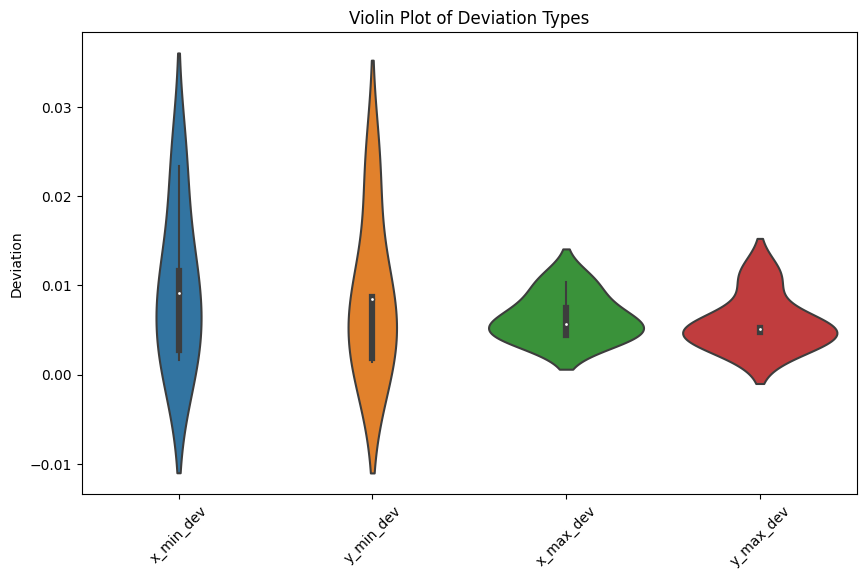

In [125]:
# Violin plot for deviation types
plt.figure(figsize=(10, 6))
sns.violinplot(data=deviation_summary)
plt.title('Violin Plot of Deviation Types')
plt.ylabel('Deviation')
plt.xticks(rotation=45)
plt.show()


<Figure size 1000x600 with 0 Axes>

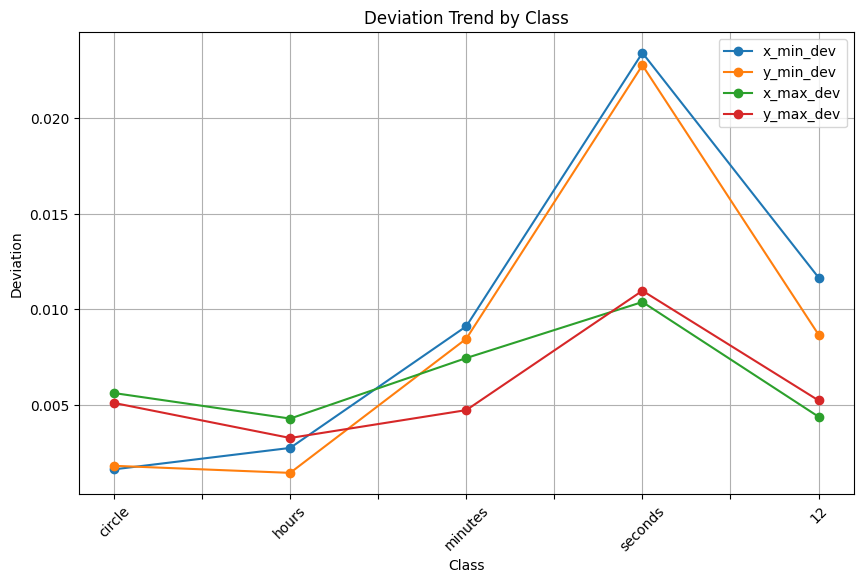

In [126]:
# Line plot for each deviation type across classes
plt.figure(figsize=(10, 6))
deviation_summary.plot(kind='line', marker='o', figsize=(10, 6))
plt.title('Deviation Trend by Class')
plt.xlabel('Class')
plt.ylabel('Deviation')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


# ------------------------------------------------------------------------------

# CSV creation and convergion of the json files to txt

In [80]:
import os

def sort_txt_files_in_folder(folder_path):
    # Iterate through all files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):  # Process only .txt files
            file_path = os.path.join(folder_path, filename)
            
            # Read the content of the file
            with open(file_path, 'r') as file:
                lines = file.readlines()

            # Sort the lines by the first number in each line
            sorted_lines = sorted(lines, key=lambda line: int(line.split()[0]))

            # Write the sorted lines back to the file
            with open(file_path, 'w') as file:
                file.writelines(sorted_lines)

if __name__ == "__main__":
    folder_path = input("Enter the folder path containing .txt files: ").strip()
    if os.path.exists(folder_path) and os.path.isdir(folder_path):
        sort_txt_files_in_folder(folder_path)
        print("All .txt files in the folder have been sorted.")
    else:
        print("The specified folder path does not exist or is not a directory.")


All .txt files in the folder have been sorted.


In [79]:
import os
import json
from PIL import Image

# Função para obter as dimensões de uma imagem
def get_image_dimensions(image_path):
    with Image.open(image_path) as img:
        return img.size  # Retorna (largura, altura)

# Caminhos para as pastas
image_folder = r"C:\VC\analogic-watch-detector-main\dataset\images\val"
json_folder = r"C:\VC\analogic-watch-detector-main\results\detections"
output_folder = r"C:\VC\analogic-watch-detector-main\yolo_format"

# Garantir que a pasta de saída exista
os.makedirs(output_folder, exist_ok=True)

# Iterar por todos os arquivos de imagem na pasta
for image_name in os.listdir(image_folder):
    if image_name.endswith(".jpg"):
        # Caminho completo da imagem
        image_path = os.path.join(image_folder, image_name)

        # Determinar o nome correspondente do arquivo JSON
        json_file_name = image_name.replace(".jpg", "_detection.json")
        json_path = os.path.join(json_folder, json_file_name)

        if not os.path.exists(json_path):
            print(f"Arquivo JSON correspondente não encontrado para {image_name}. Pulando...")
            continue

        # Obter dimensões da imagem
        img_width, img_height = get_image_dimensions(image_path)

        # Carregar dados JSON
        with open(json_path, "r") as json_file:
            data = json.load(json_file)

        # Nome do arquivo de saída
        output_file = os.path.join(output_folder, image_name.replace(".jpg", ".txt"))

        # Processar e salvar em formato YOLO
        with open(output_file, "w") as yolo_file:
            for frame in data:  # Iterar por cada frame no JSON
                # Filtrar objetos por classe e manter apenas o de maior confiança
                filtered_objects = {}
                for obj in frame:
                    class_id = obj["class_id"]
                    confidence = obj.get("confidence", 0)  # Considerar confiança, se disponível

                    # Substituir apenas se a confiança for maior
                    if class_id not in filtered_objects or confidence > filtered_objects[class_id].get("confidence", 0):
                        filtered_objects[class_id] = obj

                # Escrever os objetos filtrados no arquivo de saída
                for obj in filtered_objects.values():
                    x_min, y_min, x_max, y_max = obj["box"]
                    class_id = obj["class_id"]

                    # Converter para o formato YOLO
                    x_center = ((x_min + x_max) / 2) / img_width
                    y_center = ((y_min + y_max) / 2) / img_height
                    width = (x_max - x_min) / img_width
                    height = (y_max - y_min) / img_height

                    # Escrever no arquivo no formato: class_id x_center y_center width height
                    yolo_file.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

        print(f"Conversão concluída para {image_name}. Arquivo salvo como {output_file}.")

print("Processamento concluído para todos os arquivos.")


Conversão concluída para watch100.jpg. Arquivo salvo como C:\VC\analogic-watch-detector-main\yolo_format\watch100.txt.
Conversão concluída para watch104.jpg. Arquivo salvo como C:\VC\analogic-watch-detector-main\yolo_format\watch104.txt.
Conversão concluída para watch108.jpg. Arquivo salvo como C:\VC\analogic-watch-detector-main\yolo_format\watch108.txt.
Conversão concluída para watch120.jpg. Arquivo salvo como C:\VC\analogic-watch-detector-main\yolo_format\watch120.txt.
Conversão concluída para watch126.jpg. Arquivo salvo como C:\VC\analogic-watch-detector-main\yolo_format\watch126.txt.
Conversão concluída para watch127.jpg. Arquivo salvo como C:\VC\analogic-watch-detector-main\yolo_format\watch127.txt.
Conversão concluída para watch134.jpg. Arquivo salvo como C:\VC\analogic-watch-detector-main\yolo_format\watch134.txt.
Conversão concluída para watch136.jpg. Arquivo salvo como C:\VC\analogic-watch-detector-main\yolo_format\watch136.txt.
Conversão concluída para watch139.jpg. Arquivo s